In [1]:
import os  # Dosya ve klasör işlemleri için (örneğin klasör oluşturma, dosya okuma/yazma)
import numpy as np  # Sayısal işlemler ve resim verilerini dizi (array) olarak işlemek için
import random  # Veri artırma için rastgele değerler üretmek amacıyla
from PIL import Image, ImageEnhance  # Görüntü işleme ve görüntülerin parlaklık/kontrast gibi özelliklerini artırmak için
from tensorflow.keras.preprocessing.image import load_img  # Görüntü dosyalarını yüklemek için
from tensorflow.keras.models import Sequential  # Katman katman model oluşturmak için
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # Model katmanları (girdi, düzleştirme, dropout, tam bağlı katman)
from tensorflow.keras.optimizers import Adam  # Modeli optimize etmek için kullanılan Adam optimizasyon algoritması
from tensorflow.keras.applications import VGG16  # Önceden eğitilmiş VGG16 modelini kullanmak için
from sklearn.utils import shuffle  # Veri setini karıştırmak (shuffle) için, böylece model eğitimi sırasında veri sırası karışır


In [2]:
# Klasör yolları
train_dir = '/Users/osman/Desktop/MRI_DeepLearning/Dataset/Training'
test_dir = '/Users/osman/Desktop/MRI_DeepLearning/Dataset/Testing'

# Eğitim verisi yükleme
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):  # Sadece klasörleri al
        for image in os.listdir(label_path):
            train_paths.append(os.path.join(label_path, image))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Test verisi yükleme
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    label_path = os.path.join(test_dir, label)
    if os.path.isdir(label_path):  # Sadece klasörleri al
        for image in os.listdir(label_path):
            test_paths.append(os.path.join(label_path, image))
            test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


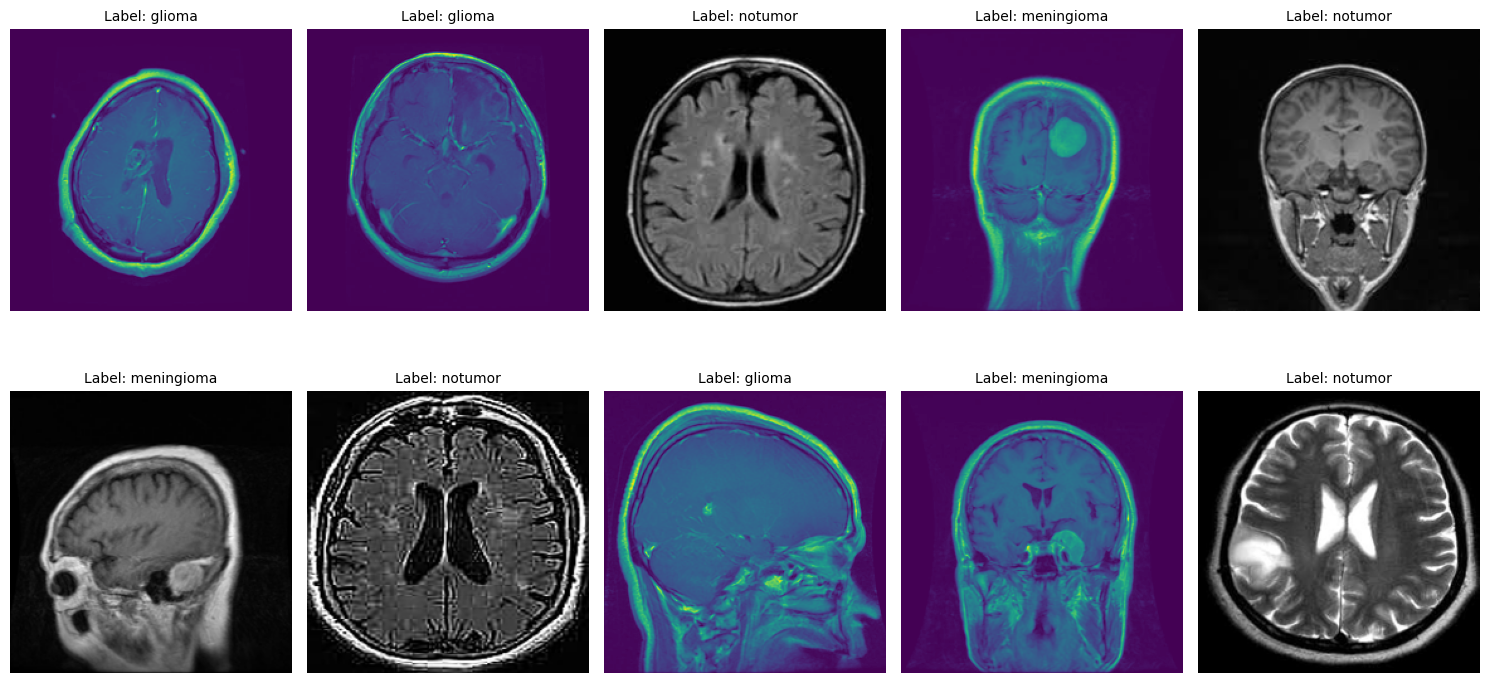

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Rastgele 10 test resmi seçmek
random_indices = random.sample(range(len(train_paths)), 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Resmi yükle
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Yeniden boyutlandır

    # Resmi görüntüle
    axes[i].imshow(img)
    axes[i].axis('off')  
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
# Görüntü artırma (augmentation) fonksiyonu
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Rastgele parlaklık
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Rastgele kontrast
    image = np.array(image) / 255.0  
    return image

# Resimleri yükle ve Görüntü arttırmayı uygula
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Etiketleri sayısal değerlere dönüştürme fonksiyonu (label encoding)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)


# Veri üreticisi (generator) fonksiyonu
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels) 
            yield batch_images, batch_labels 

In [5]:
# Model mimarisi
IMAGE_SIZE = 128  # Image size
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Tüm katmanları dondur (VGG16 base model)
for layer in base_model.layers:
    layer.trainable = False

# Son birkaç yeni katman eklendi (eğitilebilir)
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Modeli build al
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  
model.add(base_model)  # VGG16 base model
model.add(Flatten())  
model.add(Dropout(0.3)) 
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.2))  
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  

# Modeli compile et
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parametreler
batch_size = 20
steps = int(len(train_paths) / batch_size)  
epochs = 10

# Modeli eğit
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
285/285 [==============================] - 82s 286ms/step - loss: 0.4761 - sparse_categorical_accuracy: 0.8170
Epoch 2/10
285/285 [==============================] - 84s 295ms/step - loss: 0.2280 - sparse_categorical_accuracy: 0.9137
Epoch 3/10
285/285 [==============================] - 85s 297ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9371
Epoch 4/10
285/285 [==============================] - 85s 298ms/step - loss: 0.1165 - sparse_categorical_accuracy: 0.9580
Epoch 5/10
285/285 [==============================] - 85s 300ms/step - loss: 0.0844 - sparse_categorical_accuracy: 0.9686
Epoch 6/10
285/285 [==============================] - 86s 301ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9735
Epoch 7/10
285/285 [==============================] - 86s 300ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9768
Epoch 8/10
285/285 [==============================] - 86s 302ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9872
Epoch 9/10
285/285 [====

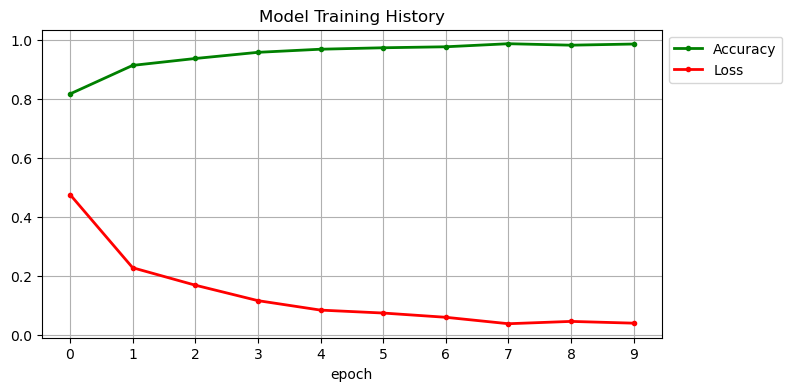

In [6]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np


test_images = open_images(test_paths) 
test_labels_encoded = encode_label(test_labels) 


test_predictions = model.predict(test_images)


print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 [==============================] - 15s 370ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       300
           2       1.00      1.00      1.00       405
           3       0.97      0.97      0.97       300
           4       0.96      0.96      0.96       306

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



Confusion Matrix:
[[298   0   0   2]
 [  0 405   0   0]
 [  0   0 290  10]
 [  2   0   9 295]]


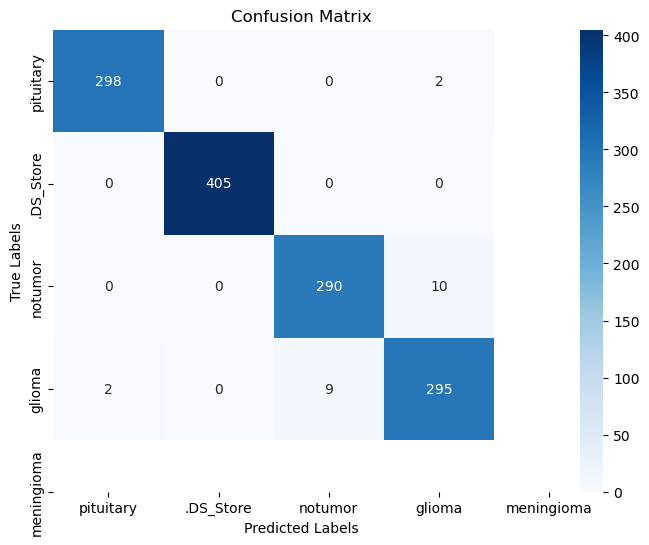

In [8]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


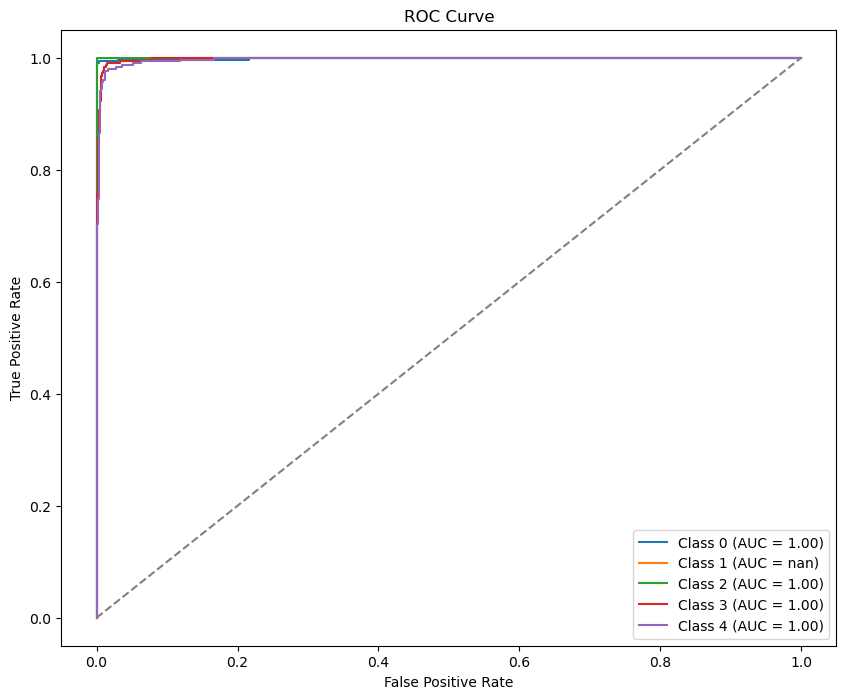

In [9]:
# 4. ROC ve AUC eğrileri
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions 


fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [11]:
# Modeli Kaydet
model.save('model.h5')

In [12]:
from tensorflow.keras.models import load_model
# eğitilmiş modeli yükle
model = load_model('model.h5')

In [14]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  
        img_array = np.expand_dims(img_array, axis=0)  

     
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

       
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

      
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 [==============================] - 0s 73ms/step


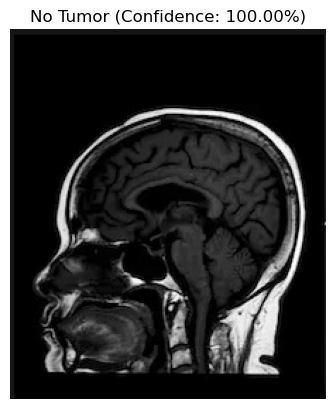

In [15]:

image_path ='/Users/osman/Desktop/MRI_DeepLearning/no.jpg'  
detect_and_display(image_path, model)

1/1 [==============================] - 0s 38ms/step


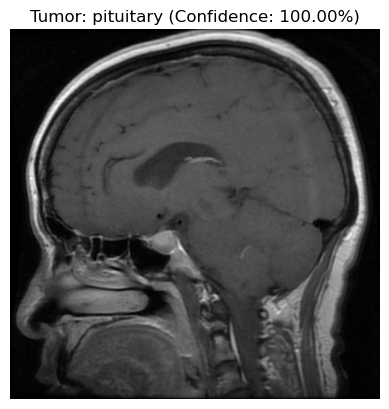

In [16]:

image_path ='/Users/osman/Desktop/MRI_DeepLearning/pi.jpg'  
detect_and_display(image_path, model)